# Practical Data Science Report
### John 'Eoin' Cronin-McCartney

Student no: 20221758



## An exploration of QA Data with multiple languages

I believe that Question-Answer systems designed to facilitate knowledge seeking should be able to retrieve across language barriers, users should not have to learn a new language before being able to pursue their professional, academic or personal information needs. In order to utilise information from languages we can train QA systems with multiple languages.
My goal is to develop a system that can retrieve data cross-lingually [1] that is data which can answer questions posed in one language, language A, where the information is found in another, language B.
Many available datasets are multi-lingual where there are multiple languages but all questions asked in language A are also answered in language A, language B in language B and so on. Multi-lingual datasets still provide a lot of use in training cross-lingual systems as they often contain data in low resource languages which are always in demand for training in multiple languages.

In this assignment I explore a dataset, tydi QA [2] I have previously not worked with in order to understand its attributes and the possible utilities it can provide me when training a cross-lingual system.

In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from datasets import load_dataset
from iso639 import languages
%matplotlib inline

#### Using HuggingFace library

HugginFace Datasets [3] is a library for easily accessing and sharing datasets, and evaluation metrics for Natural Language Processing (NLP), computer vision, and audio tasks.
I am using the library today as it is common for the library to employed in the development of Question Answering models and is easily compatible with the Pandas package which I am also using today.

In [267]:
tydi_ds =  load_dataset('tydiqa','primary_task')

Reusing dataset tydiqa (/Users/johncmcc/.cache/huggingface/datasets/tydiqa/primary_task/1.0.0/b8a6c4c0db10bf5703d7b36645e5dbae821b8c0e902dac9daeecd459a8337148)
100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


### Exploring Data
Pandas is an open source Python package widely used for data science and analysis and is commonly employed in machine learning tasks.<br>
For the goal of understanding and exploring the selected dataset pandas offers a lot of advantages including:
- Integration with Jupyter notebooks allows for single space for data manipulation and visualisation
    - I do not need multiple programs running a database, visualisation tool and development environment
- Taking full advantage of Python
    - All available libraries and plugins that can be used in any python program can be used with pandas data
- Powerful plotting tools using MatPlotLib

In [278]:
df_val = tydi_ds['validation'].to_pandas()
df_val.head()

,passage_answer_candidates,question_text,document_title,language,annotations,document_plaintext,document_url
0,"{'plaintext_start_byte': [1, 517, 1805, 2966, ...",หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร เรียนจบจากที่ไ...,หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร,thai,"{'passage_answer_candidate_index': [-1, -1, -1...",\nรองศาสตราจารย์[1] หม่อมราชวงศ์สุขุมพันธุ์ บร...,https://th.wikipedia.org/wiki/%E0%B8%AB%E0%B8%...
1,"{'plaintext_start_byte': [1, 280, 468, 812], '...",Ukubwa wa Rijili Kantori ni kiasi gani?,Rijili Kantori,swahili,"{'passage_answer_candidate_index': [-1, -1, -1...","\nRijili Kantori , Rijili Kantarusi au ing. Al...",https://sw.wikipedia.org/wiki/Rijili%20Kantori
2,"{'plaintext_start_byte': [1, 1124, 2274, 2571,...",అలి గౌహర్ ఎన్ని సంవత్సరాలు జీవించాడు?,అహమ్మద్ షా బహదూర్,telugu,"{'passage_answer_candidate_index': [27, -1, -1...","\nఅహమ్మద్ షా బహదూర్, మిర్జా అహమ్మద్ షా, షహన్‌ష...",https://te.wikipedia.org/wiki/%E0%B0%85%E0%B0%...
3,"{'plaintext_start_byte': [0, 351, 553, 1244, 1...",Milloin Kokemäki on perustettu?,Kokemäki,finnish,"{'passage_answer_candidate_index': [-1, 16, -1...","\nKokemäki () on Suomen kaupunki, joka sijaits...",https://fi.wikipedia.org/wiki/Kokem%C3%A4ki
4,"{'plaintext_start_byte': [1, 1091, 2520, 3062,...",১৯৮১ সালে বাংলাদেশের সেনাবাহিনীর সেনাপ্রধান কে...,হুসেইন মুহাম্মদ এরশাদ,bengali,"{'passage_answer_candidate_index': [-1, -1, -1...","\nহুসেইন মুহাম্মদ এরশাদ (ফেব্রুয়ারি ১, ১৯৩০) ...",https://bn.wikipedia.org/wiki/%E0%A6%B9%E0%A7%...


In [279]:
print(df_val.size)
print(df_val.dtypes)

130690
passage_answer_candidates    object
question_text                object
document_title               object
language                     object
annotations                  object
document_plaintext           object
document_url                 object
dtype: object


Our dataset contains no numeric values so the object format correctly identifies all of our columns as strings or as objects in the case of `passage_answer_candidates` and `annotations`

### Checking for question - answer language parity

There are a number of different methodologies in creating multilingual QA datasets, in some datasets we see questions asked in one language where the answer is given in another language.
Below we can see that the first question has a corresponding answer in a wikipedia edition of the same language.

In [280]:
df_val.loc[0:0,['language','document_url']]

,language,document_url
0,thai,https://th.wikipedia.org/wiki/%E0%B8%AB%E0%B8%...


The language of the first question in the training data is Thai, the Wikipedia URL where the answer is found contains 'th' this is an `iso-639-1` code[4] this particular code tells us that the language of the wikipedia edition is also Thai.

To explore all questions in the dataset we could manually check that all URLs contain the correct iso-639-1 code but it is much more efficient to use the tools available to us in pandas to generate a simple comparison table.

#### Using regex to confirm URL uniformity
We can check to make sure that all URLs in our data are uniform in nature, this is essential as if some of the URLS do not contain the iso code then there will be errors when comparing the question and answer language origins.<br><br>
Regular expressions with a negated predicate can be used to return all non-matching URLs.<br>
The regular expression matches strings which:
- Start with the `https` protocol
- Followed by a 2 character subdomain (the iso code)
- Complete the standard section of the Wikipedia URL

In [281]:
# Check that all urls follow the same pattern
# Returns a dataframe of all URLs which do not match the following regular expression, expect size of frame to be 0 when all URLs match our regex
print('Non-matching URLs = ', df_val[~df_val['document_url'].str.contains('https:\/\/[A-Za-z]{2}\.wikipedia.org')].size)

Non-matching URLs =  0


#### Converting a URL to a country name
We now know that the URLs in question are all uniform in format.<br>
All URLs will have an iso-639-1 code and by employing a python library we can convert these iso codes to a comparable format as the language field of our dataset.

We design a function to perform:
- Assign characters 9 and 10 of URL as country code
- Use iso639 to convert code to language
- Format the language to remove the any superfluous information and convert to lower case
    - e.g. 'Swahili macrolanguage' is converted to 'swahili'

In [282]:
# Extract the URLS to have only the location code
def get_ans_lang(url):    
    country_code = url[8:10]    
    language_full = languages.get(alpha2=country_code).name    
    l_formatted = str(language_full).split()[0].lower()
    return l_formatted

Test using the first URL we see the conversion to the correct language in the correct format

In [283]:
print(df_val.document_url[0][:35]+"...")
print("The Answer langauge is:", get_ans_lang(df_val.document_url[0]))

https://th.wikipedia.org/wiki/%E0%B...
The Answer langauge is: thai


#### Creating a new column to contain the answer
With a reusable function to convert URLs to languages we can now apply this to the entire document_url column and insert a new column to our dataframe.

In [284]:
df_val.insert(6, "answer_language", df_val['document_url'].apply(get_ans_lang))
df_val.head()

,passage_answer_candidates,question_text,document_title,language,annotations,document_plaintext,answer_language,document_url
0,"{'plaintext_start_byte': [1, 517, 1805, 2966, ...",หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร เรียนจบจากที่ไ...,หม่อมราชวงศ์สุขุมพันธุ์ บริพัตร,thai,"{'passage_answer_candidate_index': [-1, -1, -1...",\nรองศาสตราจารย์[1] หม่อมราชวงศ์สุขุมพันธุ์ บร...,thai,https://th.wikipedia.org/wiki/%E0%B8%AB%E0%B8%...
1,"{'plaintext_start_byte': [1, 280, 468, 812], '...",Ukubwa wa Rijili Kantori ni kiasi gani?,Rijili Kantori,swahili,"{'passage_answer_candidate_index': [-1, -1, -1...","\nRijili Kantori , Rijili Kantarusi au ing. Al...",swahili,https://sw.wikipedia.org/wiki/Rijili%20Kantori
2,"{'plaintext_start_byte': [1, 1124, 2274, 2571,...",అలి గౌహర్ ఎన్ని సంవత్సరాలు జీవించాడు?,అహమ్మద్ షా బహదూర్,telugu,"{'passage_answer_candidate_index': [27, -1, -1...","\nఅహమ్మద్ షా బహదూర్, మిర్జా అహమ్మద్ షా, షహన్‌ష...",telugu,https://te.wikipedia.org/wiki/%E0%B0%85%E0%B0%...
3,"{'plaintext_start_byte': [0, 351, 553, 1244, 1...",Milloin Kokemäki on perustettu?,Kokemäki,finnish,"{'passage_answer_candidate_index': [-1, 16, -1...","\nKokemäki () on Suomen kaupunki, joka sijaits...",finnish,https://fi.wikipedia.org/wiki/Kokem%C3%A4ki
4,"{'plaintext_start_byte': [1, 1091, 2520, 3062,...",১৯৮১ সালে বাংলাদেশের সেনাবাহিনীর সেনাপ্রধান কে...,হুসেইন মুহাম্মদ এরশাদ,bengali,"{'passage_answer_candidate_index': [-1, -1, -1...","\nহুসেইন মুহাম্মদ এরশাদ (ফেব্রুয়ারি ১, ১৯৩০) ...",bengali,https://bn.wikipedia.org/wiki/%E0%A6%B9%E0%A7%...


#### Question - Answer language parity
With our newly created answer_language field comprising the same format as the language field we are now ready to do a direct comparison between the two.<br>
The simplest comparison to make is to check if the counts of the two are equal. It is likely that if some questions are asked in one language but answered in another that the counts between at least 2 pairs of languages are different, if they are the same it is likely that all questions asked in a language are answered in the same.<br><br>
We create 2 arrays of integers by using the value counts function. This function returns an array of all languages and the cumulative counts of each language in the given column

In [285]:
q_count = df_val['language'].value_counts()
a_count = df_val['answer_language'].value_counts()
q_count

telugu        2479
swahili       2288
thai          2245
finnish       2082
indonesian    1805
japanese      1709
korean        1698
russian       1625
arabic        1380
english       1031
bengali        328
Name: language, dtype: int64

Creating a new dataframe from the 2 arrays we can see that there is an identical count for language question origin and answer origin

In [286]:
df_l_count = pd.concat([q_count,a_count], axis=1, keys=['Question','Answer'])
df_l_count

,Question,Answer
telugu,2479,2479
swahili,2288,2288
thai,2245,2245
finnish,2082,2082
indonesian,1805,1805
japanese,1709,1709
korean,1698,1698
russian,1625,1625
arabic,1380,1380
english,1031,1031


Although unlikely, it is not impossible that some answers are answered by other languages which just happen to be perfectly symmetrical in difference.<br>
For example 1 English answer for a Russian question and one Russian answer for an English question would give us exact counts.<br>
To be certain we can check that there are no questions in one language with an answer in another using the following.

In [287]:
df_compare = np.where(df_val['language'] != df_val['answer_language'])

print('Question language is different to Answer language in ', df_compare[0].size, 'entries')

Question language is different to Answer language in  0 entries


## Visualising the differences in the test and validation sets.
We have discovered that this dataset does not utilise Questions asked in one language that are answered only in another.<br>
While the dataset is `multi-lingual` we can say that is is not `cross-lingual`.<br>
Applying data science techniques is what allows useful explorations of data before use and even though the data is not cross-lingual it still can be used for training and testing QA models and it is worth exploring its other properties.

I want to start by looking comparing the language data between the `Validation` split that has been used up to now and the `Training` split.

In [288]:
df_train = tydi_ds['train'].to_pandas()
df_train.head()

,passage_answer_candidates,question_text,document_title,language,annotations,document_plaintext,document_url
0,"{'plaintext_start_byte': [1, 660, 844, 1196, 1...",berapakah jenis ras yang ada didunia?,Ras manusia,indonesian,"{'passage_answer_candidate_index': [-1], 'mini...","\ntransl.\n\nRas (dari bahasa Prancis race, ya...",https://id.wikipedia.org/wiki/Ras%20manusia
1,"{'plaintext_start_byte': [1, 271, 995, 1763, 2...",2018年アメリカで一番治安の悪い州はどこ,デトロイト,japanese,"{'passage_answer_candidate_index': [-1], 'mini...",\n\n\nデトロイト（ /dɨˈtrɔɪt/）は、アメリカ合衆国ミシガン州南東部にある都市...,https://ja.wikipedia.org/wiki/%E3%83%87%E3%83%...
2,"{'plaintext_start_byte': [0, 208, 542, 891, 10...","Je,Ngamia anaweza kaa bila maji kwa muda gani?",Kuku,swahili,"{'passage_answer_candidate_index': [-1], 'mini...",\nKuku (Gallus gallus domesticus) ni ndege ana...,https://sw.wikipedia.org/wiki/Kuku
3,"{'plaintext_start_byte': [5, 401, 1185, 2103, ...",কম্পিউটার বিজ্ঞানের মোট কয়টি শাখা রয়েছে ?,বিজ্ঞান,bengali,"{'passage_answer_candidate_index': [-1], 'mini...",\n\n\n\n\n\n\n\nভৌত বিশ্বের যা কিছু পর্যবেক্ষণ...,https://bn.wikipedia.org/wiki/%E0%A6%AC%E0%A6%...
4,"{'plaintext_start_byte': [0, 395, 716, 1320, 3...",మెదక్ నగర విస్తీర్ణం ఎంత?,మెదక్ జిల్లా,telugu,"{'passage_answer_candidate_index': [-1], 'mini...",మెదక్ జిల్లా తెలంగాణ రాష్ట్రంలోని 31 జిల్లాలలో...,https://te.wikipedia.org/wiki/%E0%B0%AE%E0%B1%...


### Comparing size of splits:
Visualisation of size differences between `train` and `validation`.<br>
Comparing overall size differences as well as the ratio of language differences between the two sets.<br>

My first goal is to display the relative sizes of each dataset by showing each as a simple circle.<br>
I need to calculate the radius of each circle and plot them

In [289]:
bubble_s = [df_train.size,df_val.size]
bubble_r = (np.sqrt(bubble_s)/np.pi)
bubble_lbl = ["Train: "+str(bubble_s[0]),"Validation: "+str(bubble_s[1])]



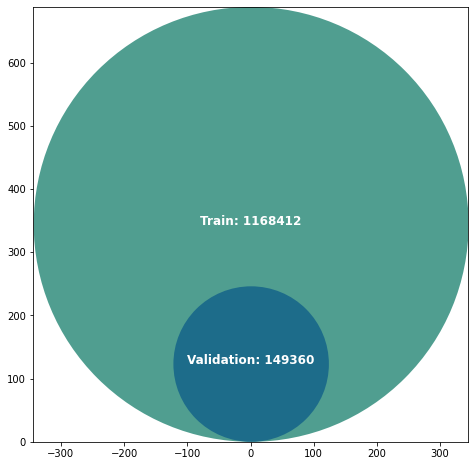

In [290]:
fig, ax = plt.subplots(figsize=(8, 8))

colours=sns.color_palette("crest", n_colors=len(bubble_s))
for i,radius in enumerate(bubble_r):
    circle = plt.Circle((1, radius), radius, facecolor=colours[i])
    ax.text(0, radius, bubble_lbl[i], horizontalalignment='center', size='large', color='white', weight='semibold')
    ax.add_artist(circle)

ax.set_xlim(-max(bubble_r), max(bubble_r))
ax.set_ylim(0, 2 * max(bubble_r))
ax.set_aspect('equal')

plt.show()


#### Comparing the language amount in each split
Given the massive volume of the `train` dataset it is difficult to show the difference between each language in splits as the training data dwarfs the validation data.<br>
Instead using the ratio of difference between the splits as a baseline we can see if some languages are comparatively better represented in validation or training sets.<br>
For instance if there is a lower ratio of English validation questions to training questions than the baseline we can say that the English language is better represented in the validation set than on average.<br>

A data frame containing the ratios of each language can be displayed visually for a quick reference

In [291]:
val_count = df_val['language'].value_counts()
train_count = df_train['language'].value_counts()

df_ratio = pd.concat([train_count,val_count], axis=1, keys=['train','validation'])

df_ratio.insert(2, "ratio", (df_ratio['train']/df_ratio['validation']).round(2))
df_ratio

,train,validation,ratio
telugu,24558,2479,9.91
arabic,23092,1380,16.73
swahili,17613,2288,7.70
japanese,16288,1709,9.53
finnish,15285,2082,7.34
indonesian,14952,1805,8.28
russian,12803,1625,7.88
thai,11365,2245,5.06
korean,10981,1698,6.47
bengali,10768,328,32.83


Now that we have the ratios of each we want to plot the values against the base ratio.<br>
First we take find the ratio of the splits `validation` to `train` and we divide that ratio by each of our language ratios.<br>
We want to compare the magnitude in difference between the base ratio and the language ratio.<br>
So if we have any values of `< 1` then we will take the negative inverse and plot below the baseline.

In [292]:
split_ratio = (df_train.size / df_val.size).round(2)

def get_magnitude(r1):
    mag = split_ratio / r1
    if mag > 1:
        return mag
    else:
        mag = (mag**-1)*-1
    return mag

df_ratio.insert(3, "magnitude", df_ratio['ratio'].apply(get_magnitude))
print("The ratio between the validation split and train split is 1 validation question for every "+str(split_ratio)+" train questions")

The ratio between the validation split and train split is 1 validation question for every 7.82 train questions


#### Ratio magnitudes can now be displayed!

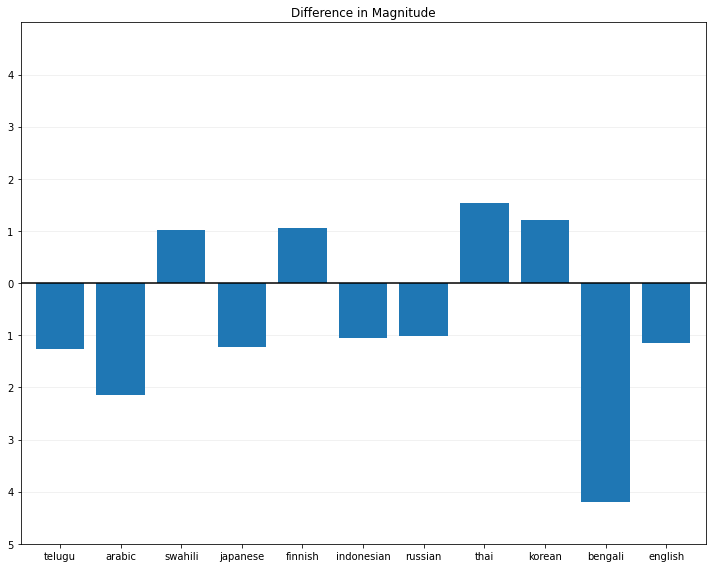

In [293]:
graph_limit = round(max(abs(df_ratio['magnitude']))) + 1
fig, ax = plt.subplots(figsize=(10, 8))

ax = df_ratio['magnitude'].plot(kind='bar', title='Difference in Magnitude', rot=0, align='center', width=.8)

ax.set_ylim(-graph_limit, graph_limit)
ax.set_yticks(np.arange(-graph_limit, graph_limit, 1))
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.axhline(0,color='black')
ax.yaxis.set_major_formatter(lambda x, pos: f'{abs(x):g}')
fig.tight_layout()
plt.show()

We can easily see the from this graph that the ratio of `validation` to `train` question in bengali is 4 times smaller than the overall ratio so we can say that bengali is under-represented in the validation set in comparison to the train dataset.
Looking at the raw data above this is true as there are only a few hundred bengali validation questions compared to more than 10,000 training questions.

If I were to develop a model I am not sure I would feel confident with such a small bengali validation set.

## Conclusion

Exploring this dataset has let me know that although it contains data useful to my research there are caveats to how I am able to use it.<br>
Training with this dataset exclusively may not yield good cross-lingual performance as the behaviour that would have been encoded in the model is only multilingual qa behaviour.<br>
Also worth noting is that during the dataset split not all languages are reflected evenly in each split. This may cause some results to not accurately reflect the models capabilities given the discrepancy between the amount of data trained on and the amount of data tested.<br>
If I were to use this dataset I believe I would re-combine both sets and use a split which more accurately distributed question languages. 


### Sources:
1. Asai, A., Yu, X., Kasai, J., & Hajishirzi, H. (2021). One question answering model for many languages with cross-lingual dense passage retrieval. Advances in Neural Information Processing Systems, 34.
2. Clark, J. H., Choi, E., Collins, M., Garrette, D., Kwiatkowski, T., Nikolaev, V., & Palomaki, J. (2020). TyDi QA: A benchmark for information-seeking question answering in typologically diverse languages. Transactions of the Association for Computational Linguistics, 8, 454-470.
3. Lhoest, Q., del Moral, A. V., Jernite, Y., Thakur, A., von Platen, P., Patil, S., ... & Wolf, T. (2021). Datasets: A community library for natural language processing. arXiv preprint arXiv:2109.02846.
4. Loc.gov. 2022. Alpha-3 codes arranged alphabetically by English name of Language - Codes for the representation of names of languages (Library of Congress). [online](https://www.loc.gov/standards/iso639-2/php/English_list.php)
